<a href="https://colab.research.google.com/github/danyssilva/ANN/blob/main/Backpropagation_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

def criaDataset(n=400, n_classes=4):
    # Gera centros aleatórios dentro da caixa [0,1]
    centers = np.random.rand(n_classes, 2)

    # Calcula quantas amostras por cluster (distribuído uniformemente)
    n_per_class = [n // n_classes] * n_classes
    for i in range(n % n_classes):
        n_per_class[i] += 1

    # Gera os pontos para cada centro
    X = []
    y = []
    for class_id in range(n_classes):
        # Gera pontos normalmente distribuídos em torno do centro
        pts = np.random.normal(loc=centers[class_id],
                              scale=0.07,  # equivalente ao cluster_std
                              size=(n_per_class[class_id], 2))
        X.extend(pts)
        y.extend([class_id] * n_per_class[class_id])

    # Converte para arrays numpy e embaralha
    X = np.array(X)
    y = np.array(y)

    # Embaralha os dados (opcional, mas importante para treinamento)
    indices = np.random.permutation(len(X))
    X = X[indices]
    y = y[indices]

    return X, y

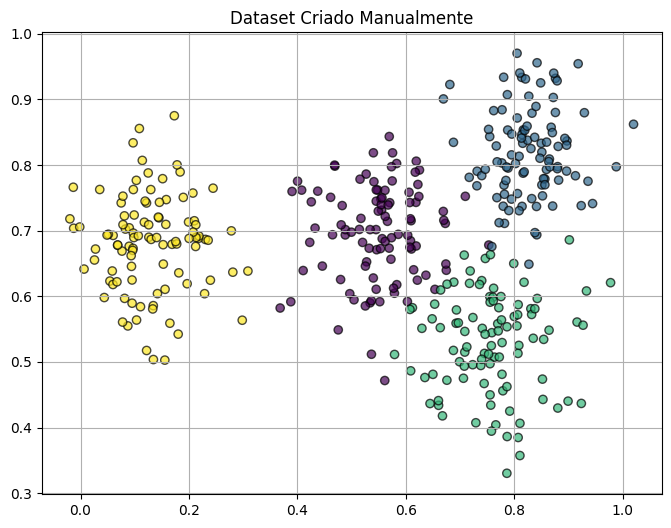

In [10]:
# Exemplo de uso: cria 400 pontos com 4 clusters
X, y = criaDataset(n=400, n_classes=4)

# Visualização (requer matplotlib)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', alpha=0.7, edgecolors='k')
plt.title("Dataset Criado Manualmente")
plt.grid(True)
plt.show()


Separa dados para treinamento e teste:

In [11]:
import numpy as np

def split_dataset(X, y, test_size=0.2):
    # Determina o número total de amostras
    total_samples = X.shape[0]

    # Calcula o número de amostras de teste
    test_size = int(total_samples * test_size)

    # Gera índices aleatórios
    indices = np.random.permutation(total_samples)

    # Divide os índices em treino e teste
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    # Separa os dados
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test

# Separar os dados em treino e teste
X_train, X_test, y_train, y_test = split_dataset(X, y, test_size=0.2)
# Verificando os tamanhos dos conjuntos
print(f"Tamanho do conjunto de treino: {X_train.shape[0]}")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]}")

Tamanho do conjunto de treino: 320
Tamanho do conjunto de teste: 80


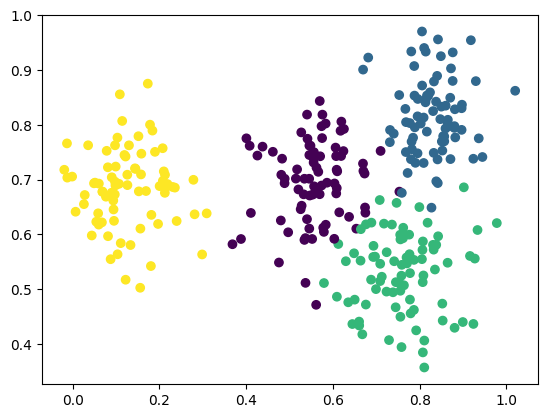

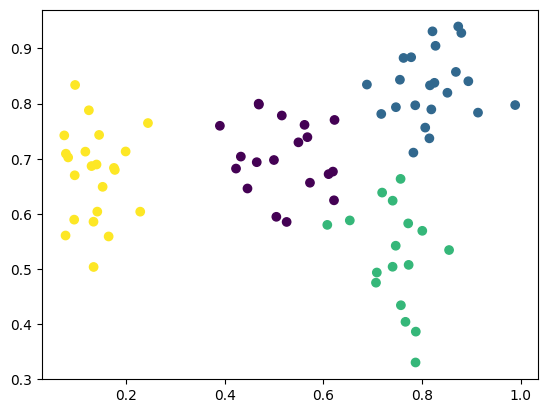

In [12]:
from matplotlib import pyplot as plt

def plotDataset(X, y):
  plt.scatter(X[:,0], X[:,1], c=y)

plotDataset(X_train, y_train)
plt.show()

plotDataset(X_test, y_test)
plt.show()

In [13]:
def defineAxes(X):
    offset = 0.5
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-offset, max1+offset, min2-offset, max2+offset]

def plotPredictions(clf, X):
    axes = defineAxes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)


In [22]:
def calcular_acuracia(y_true, y_pred):
    """
    Calcula a acurácia entre os rótulos verdadeiros e as previsões

    Parâmetros:
    y_true : array-like de shape (n_samples,)
        Rótulos verdadeiros
    y_pred : array-like de shape (n_samples,)
        Rótulos previstos

    Retorna:
    float : Acurácia entre 0.0 e 1.0
    """
    # Converte para arrays numpy se necessário
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Verifica se os shapes são compatíveis
    if y_true.shape != y_pred.shape:
        raise ValueError("Os arrays y_true e y_pred devem ter o mesmo shape")

    # Calcula o número de previsões corretas
    corretos = np.sum(y_true == y_pred)

    # Calcula a acurácia
    acuracia = corretos / len(y_true)

    return acuracia


In [14]:
from scipy.special import expit
from abc import ABC, abstractmethod

class ActivationFunction(ABC):
  @abstractmethod
  def foward(self, a):
    pass
  @abstractmethod
  def backward(self, a):
    pass

class Tanh(ActivationFunction):
  def foward(self, a):
    return expit(a)*2-1
  def backward(self, a):
    return (1 - np.square(self.foward(a)))

class Sigmoid(ActivationFunction):
  def foward(self, a):
    return expit(a)
  def backward(self, a):
    return self.foward(a)*(1-self.foward(a))


In [16]:
include_bias = lambda X: np.c_[np.ones(X.shape[0]), X]

In [38]:
# Classe para o Multi Layer Perceptron com backpropagation
class BackPropagation():
  def __init__(self, max_iter=1000, learning_rate=0.001, n_hidden=[6],
               regularization=0, activation=Tanh()):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.n_hidden = n_hidden
    self.regularization = regularization
    self.activation = activation

  def foward(self, X):
    self.A = []
    self.Z = []
    AUX = X.copy()
    for W in self.Ws:
      self.A.append(include_bias(AUX))
      self.Z.append(self.A[-1] @ W)
      AUX = self.activation.foward(self.Z[-1])
    return AUX

  def backward(self, Xb, y, ypred):
    grads = []
    output_delta = y - ypred
    grads.insert(0, self.A[-1].T @ output_delta)
    for i in range(len(self.Ws)-1, 0, -1):
      input_delta = (output_delta @ self.Ws[i][1:, :].T) * self.activation.backward(self.Z[i-1])
      grads.insert(0, self.A[i-1].T @ input_delta)
      output_delta = input_delta.copy()
    for i in range(len(self.Ws)-1, -1, -1):
      self.Ws[i] *= 1 - self.regularization * self.learning_rate
      self.Ws[i] += grads[i] * self.learning_rate

  def getWs(self, X, y):
    self.Ws = []
    previous_output = X.shape[1]
    for layer_size in self.n_hidden:
      self.Ws.append(np.random.uniform(-1, 1, size=(previous_output+1, layer_size)))
      previous_output = layer_size
    if len(y.shape) == 1:
      y = y.reshape(-1, 1)
    self.Ws.append(np.random.uniform(-1, 1, size=(previous_output+1, y.shape[1])))
    for _ in range(self.max_iter):
      ypred = self.foward(X)
      self.backward(X, y, ypred)
    return self.Ws


In [39]:
class MeuMLP:
    def __init__(self, trainingAlgorithm):
        self.trainingAlgorithm = trainingAlgorithm
        self.classes_ = None  # Para armazenar as classes únicas

    def fit(self, X, y):
        # Armazenar as classes únicas
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        # Binarizar os rótulos manualmente
        y_binarized = np.zeros((y.shape[0], n_classes))
        for idx, label in enumerate(y):
            y_binarized[idx, np.where(self.classes_ == label)[0][0]] = 1

        # Treinar o modelo
        self.w = self.trainingAlgorithm.getWs(X, y_binarized)
        return self

    def predict(self, X):
        ypred = self.trainingAlgorithm.foward(X)

        if ypred.shape[1] == 1:
            ypred = np.sign(ypred)
        else:
            # Obter a classe com a maior probabilidade
            idx = np.argmax(ypred, axis=1)
            ypred = self.classes_[idx]  # Converter de volta para as classes originais

        return ypred


In [40]:
# Supondo que você tenha uma implementação de trainingAlgorithm
mlp = MeuMLP(trainingAlgorithm=BackPropagation())
mlp.fit(X_train, y_train)
# Fazer previsões
ypred = mlp.predict(X_train)
print("Predições:", ypred)
print("Rótulos verdadeiros:", y_train)

Predições: [2 3 2 1 2 2 2 3 2 3 3 3 3 3 1 0 2 1 1 0 1 2 0 3 3 3 2 3 2 2 2 2 2 1 1 2 0
 0 2 2 2 2 2 0 2 2 3 0 0 3 0 2 3 0 2 0 3 1 3 0 3 2 3 3 2 0 0 1 0 3 0 1 1 3
 2 1 2 3 2 3 1 1 2 2 1 3 0 3 1 1 1 3 1 3 0 3 2 0 3 0 0 0 2 3 1 2 3 3 3 2 0
 3 1 2 3 2 1 2 0 3 0 0 1 1 3 0 0 2 0 1 0 0 0 3 3 2 1 2 3 0 0 1 1 0 3 2 3 2
 1 1 2 2 1 2 1 1 3 2 3 0 3 0 0 1 3 1 0 1 3 1 2 1 3 1 2 3 3 1 2 2 3 0 0 2 0
 1 1 0 2 1 2 3 2 3 1 3 1 2 1 1 2 1 3 2 1 0 3 1 0 3 0 2 0 2 1 3 2 0 1 2 3 0
 3 2 2 1 0 0 1 2 2 0 2 2 0 1 3 1 0 1 3 0 2 2 2 2 0 3 1 0 3 3 0 0 3 1 0 3 1
 2 0 3 2 0 3 0 1 1 0 2 1 3 2 0 1 2 1 2 2 3 2 1 0 0 0 2 0 1 0 0 1 0 3 3 1 3
 1 0 2 1 1 2 0 0 1 3 2 1 0 3 2 2 2 1 1 0 0 1 3 3]
Rótulos verdadeiros: [2 3 0 1 2 2 2 3 2 3 3 3 3 3 1 0 2 1 0 0 1 2 0 3 3 3 2 3 2 2 2 2 2 1 1 2 0
 0 2 2 2 2 2 0 2 2 3 0 0 3 0 2 3 0 2 0 3 1 3 0 3 2 3 3 2 0 0 1 0 3 0 1 1 3
 2 1 2 3 2 3 1 1 2 2 1 3 0 3 1 1 1 3 1 3 0 3 1 0 3 0 0 0 2 3 1 2 3 3 3 1 0
 3 1 2 3 2 1 2 0 3 0 0 1 1 3 0 0 2 0 1 0 0 0 3 3 2 1 2 3 2 0 1 1 0 3 0 3 0
 1 1 2 2 1 2 1 1 3

0.978125


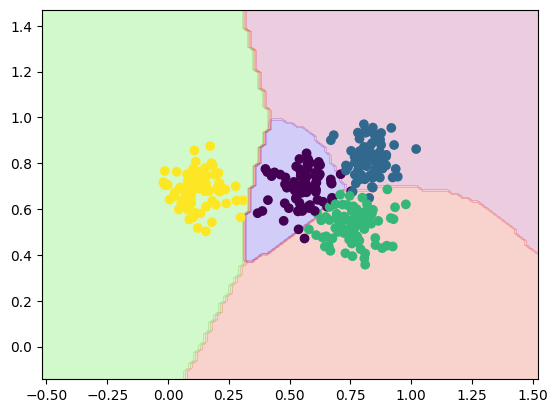

In [41]:
print(calcular_acuracia(y_train, ypred))
plotPredictions(mlp, X_train)
plotDataset(X_train, y_train)
plt.show()

0.9875


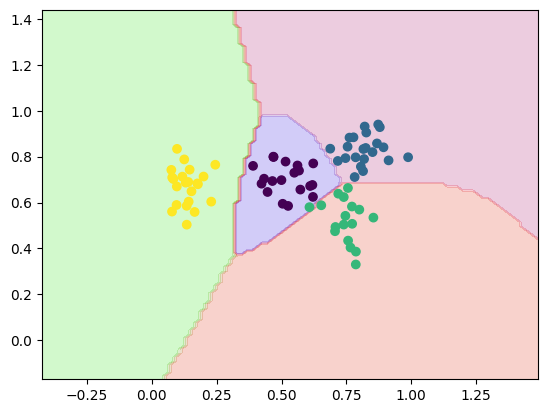

In [42]:
ypred = mlp.predict(X_test)
print(calcular_acuracia(y_test, ypred))
plotPredictions(mlp, X_test)
plotDataset(X_test, y_test)
plt.show()